# Questions

* Should I calculate business days since incident? or Total days?
* How to do timeseries?
  * Only predict a date based on the info that's happened BEFORE it?
  * Book by week? exact day of year? month?
 ---
* Could I make an EITHER/OR case?
  * First do a classifier for Compensate or Deny. If compensate, then do a Regression for HOW MUCH they'll get back?
  * I could also do models that ONLY take into account how much they asked for, IF I have enough data
* Why is my RF 410 MB?
* **I may be parsing 'ITEMS' wrong. Semicolon may indicate the various items missing**

### 1st simple model, "settle" or "compensate" I got 67.40% ROC!
### 2nd model, with claim_request_amount, roc_auc got 68.64%

# Next Steps
* Try a Rolling Window of 12 months to remove seasonality and see if there are changes from 2002 onward
* See if I can spot trends by day/week/month/holidays/weekends during the year

### *Is it an issue with 370 airports and 170 airlines?*
### I should consider dropping some of the claim_types and maybe other stuff too

# Feature engineer count of how many claims

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyspark

import datetime as dt

import tabula
import joblib

In [186]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE

In [3]:
dir = 'models/preliminary'

-----

-----

In [189]:
df = pd.read_pickle('./data/clean/clean_for_classifier_df.pkl')

In [190]:
col_names = ['claim_number', 'date_received', 'incident_date', 'airport_code', 'airport_name',
           'airline', 'claim_type', 'claim_site', 'item_category', 'close_amount', 'disposition']
           

In [191]:
df['binary_disposition'] = df['disposition']
df['binary_disposition'] = df['binary_disposition'].where(df['binary_disposition'] == 'Deny', other='Compensate')

# Change some text to make it more human readable
df.claim_site[df.claim_site == '-'] = 'Unknown'
df.claim_type[df.claim_type == '-'] = 'Unknown'

# Feature Engineering

### Count of items claimed

# TODO: Consider only using this for where claim_type is related to property.
df['num_items_or_incidents_claimed'] = df['item_category'].str.split(pat=';').apply(lambda x: len(x))
df['num_items_or_incidents_claimed'] = df['num_items_or_incidents_claimed'].where(df['claim_type'].str.contains('property', case=False) == True, other= 0)

### Time calculation
wait_period = df.date_received - df.incident_date
df['days_waited_to_file_claim'] = wait_period.dt.days

# Drop days where the 'date_received" was reported before 'incident_date'
df = df[df.days_waited_to_file_claim >= 0]

df.reset_index(inplace=True,drop=True)
df['bin_dispos_onehot'] = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
## Figure out how to plot this shit. I want 12 months on the X axis, and then a bar for each month of the proportion of approved vs denied within each month (I think)

# TIME BREAKOUT COLUMNS

In [192]:
# df['Week/Year_inc_date'] = df['incident_date'].apply(lambda x: "%d/%d" % (x.week, x.year))
# df['Week_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.week))
# df['Month_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.month))
# df['Year_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.year))

# df['Week_received'] = df['date_received'].apply(lambda x: "%d" % (x.week))
df['Month_received'] = df['date_received'].apply(lambda x: "%d" % (x.month))
# df['Year_received'] = df['date_received'].apply(lambda x: "%d" % (x.year))

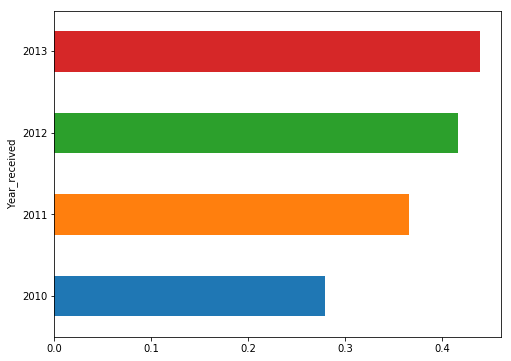

In [9]:
# df.groupby('Year_received').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6))

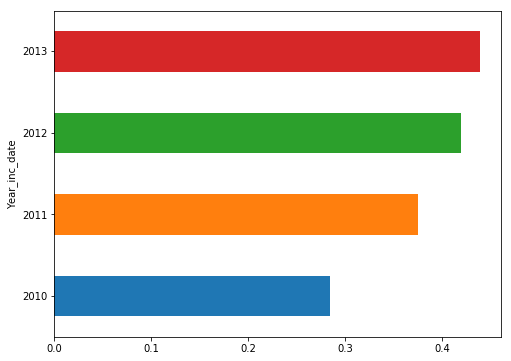

In [10]:
# df.groupby('Year_inc_date').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

In [247]:
df.columns

Index(['date_received', 'incident_date', 'airport_code', 'airline',
       'claim_type', 'claim_site', 'close_amount', 'disposition',
       'item_category', 'binary_disposition', 'num_items_or_incidents_claimed',
       'days_waited_to_file_claim', 'bin_dispos_onehot', 'Month_received'],
      dtype='object')

In [254]:
X_df = df.drop(['binary_disposition', 'disposition', 
             'date_received', 'incident_date',
             'close_amount', 'num_items_or_incidents_claimed']
            ]
            , axis=1)
y = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

In [255]:
categorical = ['airport_code', 'airline', 'claim_type', 'claim_site', 'Month_received']
continuous =  ['days_waited_to_file_claim']

In [256]:
enc = OneHotEncoder(sparse=False)
onehotarray = enc.fit_transform(X_df[categorical])

ss = StandardScaler()
continuousarray = ss.fit_transform(X_df[continuous])

mlb = MultiLabelBinarizer(sparse_output=False)
onehot_itemcategories = mlb.fit_transform(X_df['item_category'].str.replace(' ','').str.split(pat=';'))

X = np.concatenate((onehotarray, continuousarray, onehot_itemcategories), axis=1)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [259]:
trans_dir = './web_app/stat_models/transformers'

enc = OneHotEncoder(sparse=False)
enc.fit(X_df[categorical])
joblib.dump(enc, f'{trans_dir}/onehotencode.joblib')
# onehotarray = enc.transform(X[categorical])

ss = StandardScaler()
ss.fit(X_df[continuous])
joblib.dump(ss, f'{trans_dir}/standardscaler.joblib')


mlb = MultiLabelBinarizer(sparse_output=False)
mlb.fit(X_df['item_category'].str.replace(' ','').str.split(pat=';'))
joblib.dump(mlb, f'{trans_dir}/item_category.joblib')

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Model with Year included

---
some problems with this would be introducing YEAR and MONTH that has never been trained on. Is this where I need to do a timeseries thing

---

In [203]:
%%time
rf = RandomForestClassifier(random_state=42)

criterions = ['gini']#, 'entropy']
n_ests = [300]
m_depths = [25]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests, max_depth=m_depths)

grid_rf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=10, n_jobs=4)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

y_pred = grid_rf.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.7033272641221381
{'criterion': 'gini', 'max_depth': 25, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.5969929111540007


In [242]:
savedir = 'models'
joblib.dump(grid_rf.best_estimator_, f'{savedir}/rf_months_12.03.2018.joblib',compress=9)

['models/rf_months_12.03.2018.joblib']

In [318]:
import catboost
from catboost import CatBoostClassifier

In [323]:
%%time
cboost = CatBoostClassifier(learning_rate=0.1, random_seed=42)
n_ests = [300]
m_depths = [30]
    
param_grid = dict(n_estimators=n_ests, max_depth=m_depths)

cat_clf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=10, n_jobs=4)

cat_clf.fit(X_train[-30000:], y_train[-30000:])

print(cat_clf.best_score_)
print(cat_clf.best_params_)
print(cat_clf.best_estimator_)

y_pred = cat_clf.predict(X_test[-30000:])
print(roc_auc_score(y_test[-30000:], y_pred[-30000:]))

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/ex

0.7000132331531255
{'max_depth': 30, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.5942895864007496
CPU times: user 1min 13s, sys: 2.38 s, total: 1min 16s
Wall time: 14min 28s


# TIME BREAKOUT COLUMNS

In [276]:
df['Week/Year_inc_date'] = df['incident_date'].apply(lambda x: "%d/%d" % (x.week, x.year))
df['Week_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.week))
df['Month_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.month))
df['Year_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.year))

df['Week_received'] = df['date_received'].apply(lambda x: "%d" % (x.week))
df['Month_received'] = df['date_received'].apply(lambda x: "%d" % (x.month))
df['Year_received'] = df['date_received'].apply(lambda x: "%d" % (x.year))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a2761eac8>]],
      dtype=object)

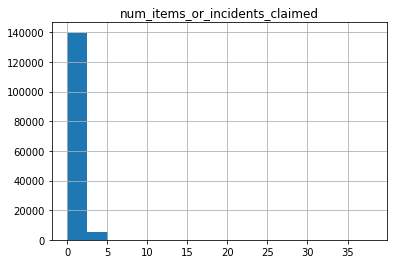

In [267]:
df.hist(column='num_items_or_incidents_claimed', bins=15)

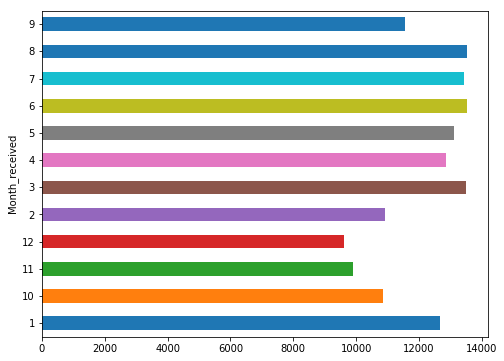

In [262]:
df.groupby('num_i').apply(lambda x: x.num_items_or_incidents_claimed.count()).plot(kind='barh', figsize=(8,6))

In [ ]:
df.plot(sort_columns=

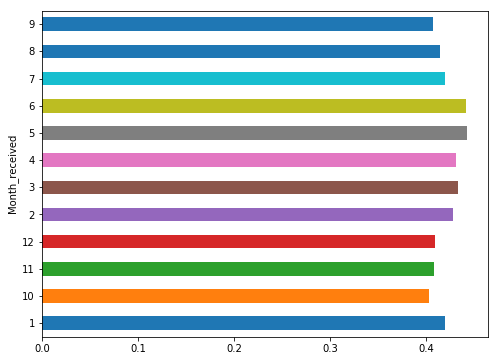

In [274]:
df.groupby('Month_received').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6), sort_columns=True)

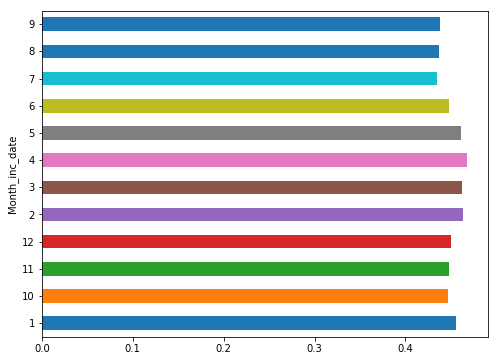

In [38]:
df.groupby('Month_inc_date').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

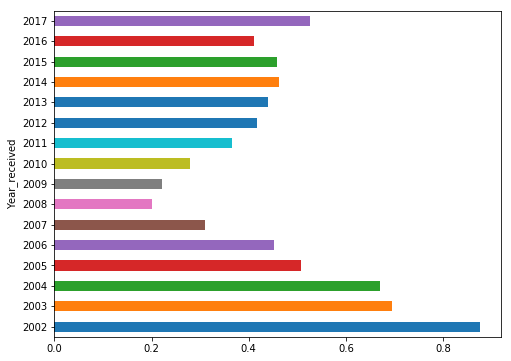

In [277]:
df.groupby('Year_received').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

In [281]:
df.head()

,date_received,incident_date,airport_code,airline,claim_type,claim_site,close_amount,disposition,item_category,binary_disposition,num_items_or_incidents_claimed,days_waited_to_file_claim,bin_dispos_onehot,Month_received,Week/Year_inc_date,Week_inc_date,Month_inc_date,Year_inc_date,Week_received,Year_received
0,2017-12-01,2017-11-30 00:00:00,MCO,Westjet Airlines Ltd,PropertyLoss,Checkpoint,17.990,Approve in Full,Household Items,Compensate,1,1,1,12,48/2017,48,11,2017,48,2017
1,2017-11-28,2017-10-22 00:00:00,LAS,UAL,PropertyLoss,Checked Baggage,90.000,Settle,Clothing,Compensate,1,37,1,11,42/2017,42,10,2017,48,2017
2,2017-11-20,2017-09-29 12:20:00,LAX,American Airlines,PropertyDamage,Checkpoint,485.550,Settle,Computer & Accessories,Compensate,1,51,1,11,39/2017,39,9,2017,47,2017
3,2017-10-26,2017-10-10 21:10:00,FLL,Emirates,PropertyLoss,Checked Baggage,111.300,Approve in Full,Other,Compensate,1,15,1,10,41/2017,41,10,2017,43,2017
4,2017-10-25,2017-05-17 00:00:00,MIA,American Airlines,PropertyLoss,Checked Baggage,65.000,Approve in Full,Baggage/Cases/Purses; Clothing,Compensate,2,161,1,10,20/2017,20,5,2017,43,2017


In [ ]:
df.mean(

In [ ]:
df.plot(

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a1807a7b8>]],
      dtype=object)

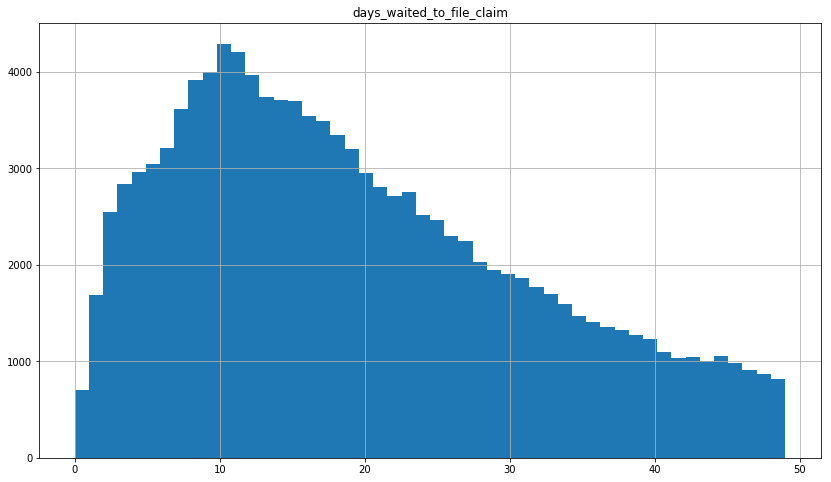

In [316]:
# 
df[df.days_waited_to_file_claim < 50].hist(column='days_waited_to_file_claim',bins=50, figsize=(14,8))

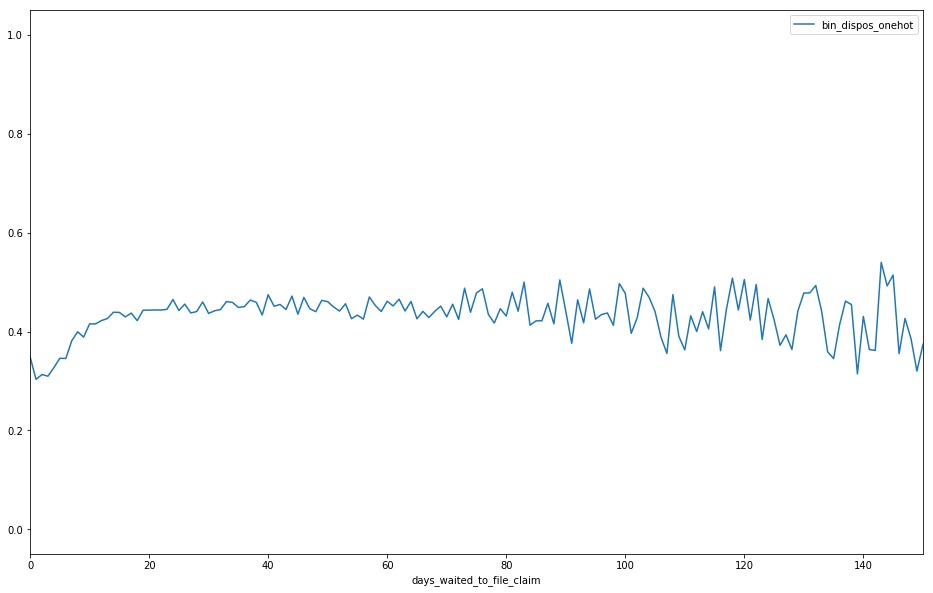

In [314]:
df.groupby('days_waited_to_file_claim').mean().plot(y='bin_dispos_onehot', xlim=(0,150),figsize=(16,10))

What are factors of play in driving results here?
What are most interesting ways to slice the data to see how the results may differ?
As a user of this model - what is the best ways I can use this information to make better decisions? (See above (file claim between 20-75). Can we get a tighter range on ideal filing time based on odds of fully/settled reimbursed?)

In [300]:
X_df.count()

airport_code                      145421
airline                           145421
claim_type                        145421
claim_site                        145421
item_category                     145421
num_items_or_incidents_claimed    145421
days_waited_to_file_claim         145421
bin_dispos_onehot                 145421
Month_received                    145421
dtype: int64

In [298]:
X_df.head()

,airport_code,airline,claim_type,claim_site,item_category,num_items_or_incidents_claimed,days_waited_to_file_claim,bin_dispos_onehot,Month_received
0,MCO,Westjet Airlines Ltd,PropertyLoss,Checkpoint,Household Items,1,1,1,12
1,LAS,UAL,PropertyLoss,Checked Baggage,Clothing,1,37,1,11
2,LAX,American Airlines,PropertyDamage,Checkpoint,Computer & Accessories,1,51,1,11
3,FLL,Emirates,PropertyLoss,Checked Baggage,Other,1,15,1,10
4,MIA,American Airlines,PropertyLoss,Checked Baggage,Baggage/Cases/Purses; Clothing,2,161,1,10


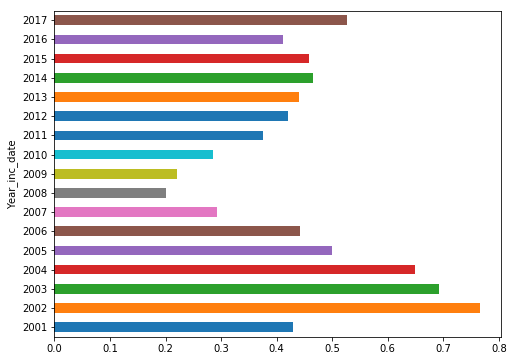

In [278]:
df.groupby('Year_inc_date').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

In [ ]:
# IT needs to be one entry in the master array. So like (1, 869)
# how do I get there? I need all the 869 features, and then I need to plug in the values as appropriate for the features I do have.

In [ ]:
# I think I need to take the big X with all the data, get its 869 feature array, then store the features for that.

# then with my example, I need to not fit_transform, but just transform it or something?!

# Model with Year included

---
some problems with this would be introducing YEAR and MONTH that has never been trained on. Is this where I need to do a timeseries thing

---